## Proyecto Final

### Integrantes
### Oziel Imanol Lemus Montelongo
### Daniel Isaí Saldaña Rocha
### Guillermo Gonzalo Veyro Ramos

## Modelo Estrella

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./vgsales.csv')

genre_sales = data.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)

platform_sales = data.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False)

publisher_sales = data.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False)

top_genres = genre_sales.head(5)
top_platforms = platform_sales.head(5)
top_publishers = publisher_sales.head(5)

print("Top 5 Géneros por Ventas Globales:")
print(top_genres)
print("\nTop 5 Plataformas por Ventas Globales:")
print(top_platforms)
print("\nTop 5 Publicadoras por Ventas Globales:")
print(top_publishers)


Top 5 Géneros por Ventas Globales:
Genre
Action          563.00
Shooter         487.12
Platform        433.80
Role-Playing    398.94
Sports          395.72
Name: Global_Sales, dtype: float64

Top 5 Plataformas por Ventas Globales:
Platform
Wii     444.46
X360    391.59
PS2     390.45
PS3     333.88
DS      312.75
Name: Global_Sales, dtype: float64

Top 5 Publicadoras por Ventas Globales:
Publisher
Nintendo                       1313.27
Activision                      304.95
Electronic Arts                 291.30
Sony Computer Entertainment     275.49
Take-Two Interactive            191.24
Name: Global_Sales, dtype: float64


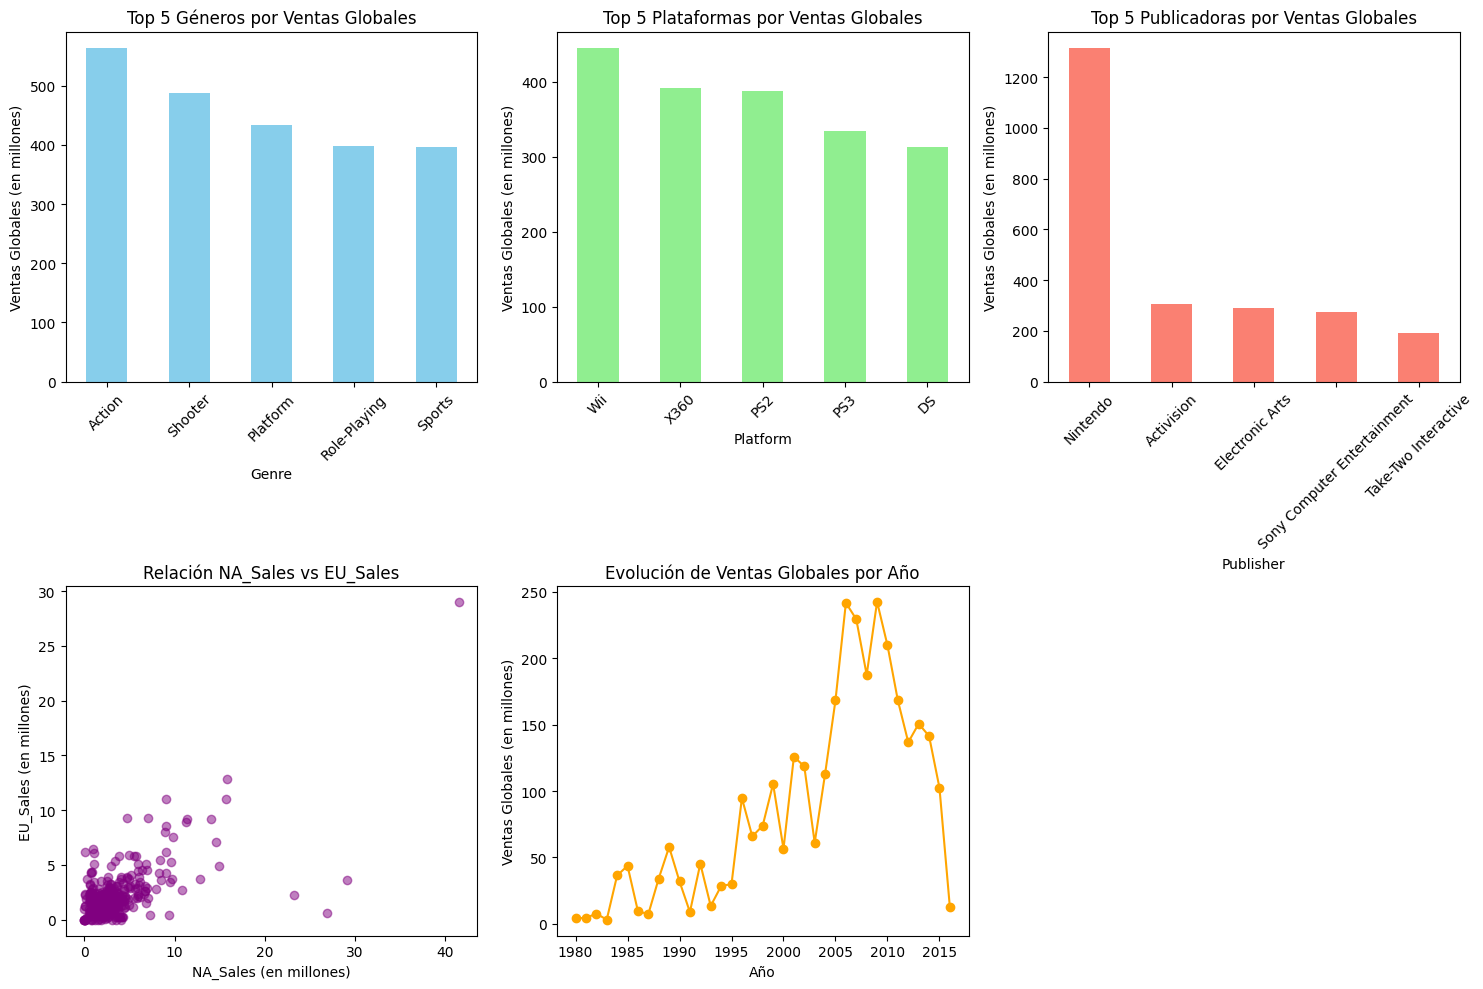

In [2]:
# Limpieza de datos
# Eliminar duplicados
data = data.drop_duplicates()

# Manejo de valores faltantes
data['Year'] = data['Year'].fillna(data['Year'].median()) 
data = data.dropna(subset=['Publisher'])

# Conversión de tipos
data['Year'] = data['Year'].astype(int)

# Gráficos exploratorios
plt.figure(figsize=(15, 10))

# Gráfico 1: Top 5 Géneros por Ventas Globales
genre_sales = data.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False).head(5)
plt.subplot(2, 3, 1)
genre_sales.plot(kind='bar', color='skyblue')
plt.title('Top 5 Géneros por Ventas Globales')
plt.ylabel('Ventas Globales (en millones)')
plt.xticks(rotation=45)

# Gráfico 2: Top 5 Plataformas por Ventas Globales
platform_sales = data.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False).head(5)
plt.subplot(2, 3, 2)
platform_sales.plot(kind='bar', color='lightgreen')
plt.title('Top 5 Plataformas por Ventas Globales')
plt.ylabel('Ventas Globales (en millones)')
plt.xticks(rotation=45)

# Gráfico 3: Top 5 Publicadoras por Ventas Globales
publisher_sales = data.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False).head(5)
plt.subplot(2, 3, 3)
publisher_sales.plot(kind='bar', color='salmon')
plt.title('Top 5 Publicadoras por Ventas Globales')
plt.ylabel('Ventas Globales (en millones)')
plt.xticks(rotation=45)

# Gráfico 4: Relación entre NA_Sales y EU_Sales
plt.subplot(2, 3, 4)
plt.scatter(data['NA_Sales'], data['EU_Sales'], alpha=0.5, color='purple')
plt.title('Relación NA_Sales vs EU_Sales')
plt.xlabel('NA_Sales (en millones)')
plt.ylabel('EU_Sales (en millones)')

# Gráfico 5: Evolución de Ventas Globales por Año
sales_by_year = data.groupby('Year')['Global_Sales'].sum()
plt.subplot(2, 3, 5)
sales_by_year.plot(kind='line', color='orange', marker='o')
plt.title('Evolución de Ventas Globales por Año')
plt.xlabel('Año')
plt.ylabel('Ventas Globales (en millones)')

plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import psycopg2


# Manejo de valores faltantes
data['Year'] = data['Year'].fillna(data['Year'].median())  
data = data.dropna(subset=['Publisher'])

# Conversión de tipos
data['Year'] = data['Year'].astype(int)

cuantitativas = data.select_dtypes(include=['int64', 'float64'])
cualitativas = data.select_dtypes(include=['object'])

# Conexión a PostgreSQL
try:
    conn = psycopg2.connect(
        user="postgres",
        password="root",
        host="localhost",
        port="5432",
        database="DbVideogamesSales"
    )
    print("Conexión exitosa a la base de datos")
except Exception as e:
    print(f"Error al conectar a la base de datos: {e}")
    exit()

# Crear cursor
cur = conn.cursor()

def crear_tabla(df, nombre_tabla, cur, conn):
    """Crea una tabla en la base de datos PostgreSQL a partir de un DataFrame."""
    dtype_mapping = {
        'object': 'TEXT',
        'int64': 'INT',
        'float64': 'FLOAT',
        'bool': 'BOOLEAN'
    }

    columns = []
    for col, dtype in zip(df.columns, df.dtypes):
        pg_type = dtype_mapping.get(str(dtype), 'TEXT')
        columns.append(f"{col} {pg_type}")

    columns_sql = ", ".join(columns)
    SQLQuery = f"CREATE TABLE IF NOT EXISTS {nombre_tabla} ({columns_sql});"
    try:
        cur.execute(SQLQuery)
        conn.commit()
        print(f"Tabla '{nombre_tabla}' creada correctamente.")
    except Exception as e:
        print(f"Error al crear la tabla '{nombre_tabla}': {e}")

def insertar_datos(df, nombre_tabla, cur, conn):
    """Inserta datos en una tabla de PostgreSQL a partir de un DataFrame."""
    df = df.where(pd.notnull(df), None)  # Reemplazar NaN por None
    columns = df.columns.tolist()
    values_template = ", ".join(["%s"] * len(columns))
    insert_query = f"INSERT INTO {nombre_tabla} ({', '.join(columns)}) VALUES ({values_template}) ON CONFLICT DO NOTHING;"

    values = [tuple(row) for row in df.to_numpy()]

    try:
        cur.executemany(insert_query, values)
        conn.commit()
        print(f"Datos insertados correctamente en la tabla '{nombre_tabla}'.")
    except Exception as e:
        conn.rollback()
        print(f"Error al insertar datos en la tabla '{nombre_tabla}': {e}")

# Crear tablas para datos cuantitativos y cualitativos
crear_tabla(cuantitativas, 'cuantitativas', cur, conn)
crear_tabla(cualitativas, 'cualitativas', cur, conn)

# Insertar datos en las tablas
insertar_datos(cuantitativas, 'cuantitativas', cur, conn)
insertar_datos(cualitativas, 'cualitativas', cur, conn)

# Cerrar conexión
cur.close()
conn.close()


Conexión exitosa a la base de datos
Tabla 'cuantitativas' creada correctamente.
Tabla 'cualitativas' creada correctamente.
Datos insertados correctamente en la tabla 'cuantitativas'.
Datos insertados correctamente en la tabla 'cualitativas'.
